# Automate Eventbrite creation from Google sheet
- This notebook connects the 'main-sheet' spreadsheet to Eventbrite to programmatically create/update events.
- Colab allows simple authentication with Google sheets, and it allows R and Python code to be run simultaneously.
- Be careful when sharing this notebook as it contains an access token to the Eventbrite API.

# Install and import needed packages

In [ ]:
!pip install ruamel.yaml
import pandas as pd
# import yaml
from ruamel.yaml import YAML
yaml = YAML()
import json
import requests
from pprint import pprint
from google.colab import auth
import gspread
from google.auth import default
from pprint import pprint
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import thread_map
import sys
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)

# Access the Google sheet
- When run, you will be asked for your google credentials.
- The notebook will use the 'sessions' sheet within the 'main-sheet' file within the 'ResBaz2023-online' folder in the CeR team drive. To change the sheet, replace with the relevant key from the URL.
 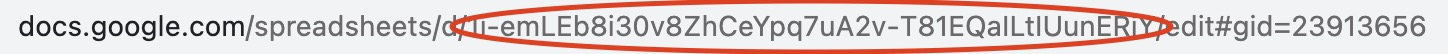
- Moving columns around might break the workflow.

In [ ]:
#authenticating to google
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
#define worksheet
# worksheet = gc.open('1WsPTaBjOWN8NahZWfKfBkZzcPuIhislTLmorsiwVQEk').
# spread_sheet = gc.open_by_key('1Lo4ax_qb5m_oO-4mCuN5hqMn5kuvqj3siaGnPRCEHnw')
spread_sheet = gc.open_by_key('1i-emLEb8i30v8ZhCeYpq7uA2v-T81EQaILtIUunERiY')
work_sheet = spread_sheet.worksheet('sessions')


#get_all_values gives a list of rows
rows = work_sheet.get_all_values()
#Convert to a DataFrame
df = pd.DataFrame(rows[1:], columns=rows[0])
orig_df = df.copy()
df

# Get the lasted schedule from the ResBaz GitHub website

In [ ]:
# thanks chatgpt

# GitHub URL of the YAML file
url = "https://raw.githubusercontent.com/UoA-eResearch/resbaz/gh-pages/_data/schedule.yml"

# Send a GET request to retrieve the content of the YAML file
response = requests.get(url)

# Get the text content of the response
content = response.text

# Replace tab characters with spaces
content = content.replace('\t', ' ')

# Parse the YAML data
data = yaml.load(content)
sessionLookup = {}
for day in data:
  date = day["date"]
  for timeslot in day["timeslots"]:
    startTime = pd.Timestamp(date + "T" + timeslot["startTime"], tz="Pacific/Auckland")#.tz_convert("UTC").strftime('%Y-%m-%dT%H:%M:%SZ')
    endTime = pd.Timestamp(date + "T" + timeslot["endTime"], tz="Pacific/Auckland")#.tz_convert("UTC").strftime('%Y-%m-%dT%H:%M:%SZ')
    for sessionId in timeslot["sessionIds"]:
      if int(sessionId) not in sessionLookup:
        sessionLookup[int(sessionId)] = []
      sessionLookup[int(sessionId)].append({
          "startTime": startTime,
          "endTime": endTime
      })
#pprint(sessionLookup)
def getSession(id, key="startTime"):
  if int(id) in sessionLookup:
    if key == "startTime":
      return min(obj[key] for obj in sessionLookup[int(id)])
    else:
      return max(obj[key] for obj in sessionLookup[int(id)])
  else:
    return pd.NA

df["start_time_Auckland"] = pd.to_datetime(df.id.apply(getSession, key="startTime"))
df["end_time_Auckland"] = pd.to_datetime(df.id.apply(getSession, key="endTime"))
df["duration"] = df.end_time_Auckland - df.start_time_Auckland
df["duration_hours"] = df.duration.round("H").dt.components.hours.astype("Int64")
df["start_time_UTC"] = df.start_time_Auckland.dt.tz_convert("UTC")
df["end_time_UTC"] = df.end_time_Auckland.dt.tz_convert("UTC")
df

In [ ]:
help(work_sheet.batch_update)

In [ ]:
pd.NA == pd.NA

In [ ]:
needs_update = df[~df.start_time_UTC.isna() & (df.start_time_UTC != orig_df.start_time_UTC)]
display(needs_update)
#updates = []
for i, row in tqdm(needs_update.iterrows(), total=len(needs_update)):
  #updates.append({"range": f"R{i+2}", "values": [[row.start_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ')]]})
  work_sheet.update(f"R{i+2}", row.start_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ'))
  work_sheet.update(f"S{i+2}", row.end_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ'))
  work_sheet.update(f"T{i+2}", row.start_time_Auckland.strftime('%Y-%m-%dT%H:%M:%S'))
  work_sheet.update(f"U{i+2}", row.end_time_Auckland.strftime('%Y-%m-%dT%H:%M:%S'))
  work_sheet.update(f"J{i+2}", row.duration_hours)
#pprint(updates)
#work_sheet.batch_update(updates)

In [ ]:
sessionLookup[31]

In [ ]:
df.duration_hours.value_counts(dropna=False)

## Determine which sessions are 'active'
- so not just left in the spreadsheet as a placeholder/unconfirmed/for next year)
- but those with a time slot booked in

In [ ]:
df_happening = df[~df.start_time_UTC.isna()]
df_happening

# Eventbrite API

## Accessing Eventrbite

The Eventbrite API requires a key to be created
https://www.eventbrite.com/platform/api#/reference/event/update/update-an-event?console=1

Testing can happen here https://www.eventbriteapi.com/v3/events/630562628797/?token=YOUR_API_KEY_HERE

In [ ]:
URL = "https://www.eventbriteapi.com/v3/events/"

headers = {
  'Authorization': 'Bearer YOUR_API_KEY_HERE',
  'Content-Type': 'application/json'
}

Eventbrite only accepts one to be set: The description OR the summary.
The summary is simply a 140 character truncated version of the description.
As this is displayed on the top of the event, it doesn't matter, we don't have to put shortened summaries!

But there is a new way to get 'structured content' published. That is a more advanced (fancy html/css) way to share details of the session.

### Test for one session

In [ ]:
pprint(requests.get(f"{URL}/630562628797", headers=headers).json())

## To delete draft Events use the following workflow.
There are three statuses:
- draft
- scheduled
- live
But these do have an overlap. If you schedule the event to be published (so people browsing our Eventbrite Account) can't see the session, it is still considered 'draft' even thought the publish button has been pressed.

In [ ]:
# Delete draft events in our organisation
response = requests.get(f"https://www.eventbriteapi.com/v3/organizations/1142785580823/events?status=draft&page_size=200", headers=headers)
events = pd.json_normalize(response.json()["events"])
display(events)
dry_run = True
if not dry_run and len(events) > 0:
  def delete_event(id):
    response = requests.delete(f"{URL}{id}", headers=headers)
    return response
  thread_map(delete_event, events.id)

As a number is required, un-capped events are set to 1000 participants max.

In [ ]:
df_happening.capacity = df_happening.capacity.replace({"open": 1000, "": 1000})

In [ ]:
next(df_happening.itertuples())

## Create the Events on Eventbrite based on the Google Sheet
- Yes, this process is even paralellised to maximise speed.
- a response '200' is what we are after
- a respone '400' means some kind of error

In [ ]:
df_happening = df_happening[df_happening.registration_link == ""]
df_happening

In [ ]:
# Make events from the gsheet
def make_event(row):
  # Copy from this template event
  response = requests.post(f"{URL}/630562628797/copy/", headers=headers)
  new_id = response.json()["id"]
  response = requests.post(f"{URL}{new_id}/", headers=headers, json={
    'event.name.html':row.title,
    'event.description.html': row.description,
    'event.start.utc': row.start_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ'),
    'event.start.timezone': 'Pacific/Auckland',
    'event.end.utc': row.end_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ'),
    'event.end.timezone': 'Pacific/Auckland',
    'event.capacity': row.capacity,
  })
  return response

responses = thread_map(make_event, df_happening.itertuples(), total=len(df_happening))
responses

## Append the newly created Events with their Eventbrite IDs and URLs to the dataframe

In [ ]:
df_happening["eventbrite_id"] = [r.json()["id"] for r in responses]
df_happening["eventbrite_url"] = [r.json()["url"] for r in responses]
df_happening

## Check what the 'structured content' gives us back

In [ ]:
pprint(requests.get(f"{URL}634393647477/structured_content/edit/", headers=headers).json())

In [ ]:
response = requests.get(f"{URL}634393376667/structured_content/edit", headers=headers)
pprint(response.json())

## Replacing placeholder descriptions

In [ ]:
df_happening.description = df_happening.description.replace("", "Description to follow soon.")

## Important: If structured content changes don't propagated, change the version
- in the URL `.../structured_content/2/'` change this to `.../structured_content/3/'` and so forth

In [ ]:
def set_structured_content(row):
  response = requests.post(f"{URL}{row.eventbrite_id}/structured_content/2/", headers=headers, json={
      "modules": [{
        "data": {
            "body": {
                "alignment": "left",
                "text": row.description
            },
            "type": "text",
        },
        "type": "text"
      }],
      "publish": True,
      'purpose': 'listing',
  })
  return response

responses = thread_map(set_structured_content, df_happening.itertuples(), total=len(df_happening))
responses

In [ ]:
status_codes = [r.status_code for r in responses]
status_codes

### Display events not resulting in the wanted 200 status code

In [ ]:
df_happening.index[pd.Series(status_codes) != 200]

In [ ]:
error_df = df_happening.loc[df_happening.index[pd.Series(status_codes) != 200]]
error_df

## Publish Events

In [ ]:
def publish_event(event_id):
  response = requests.post(f"{URL}{event_id}/publish/", headers=headers)
  return response
thread_map(publish_event, df_happening.eventbrite_id, total=len(df_happening))

In [ ]:
df_happening

# Replicate changes back to Google Sheet

In [ ]:
for i, row in tqdm(df_happening.iterrows(), total=len(df_happening)):
  work_sheet.update(f"N{i+2}", row.eventbrite_url)

## Add Zoom links (pasted into Google Sheet) to Eventbrite
Zoom links via structured content: https://www.eventbrite.com/platform/docs/online-event-page

In [ ]:
df.zoom_link != ""

In [ ]:
df["eventbrite_id"] = df.registration_link.str.split("-").str[-1]
df

In [ ]:
df_zoom = df[(df.zoom_link != "") & df.eventbrite_id]
df_zoom

In [ ]:
response = requests.get(f"{URL}634393306457/structured_content/edit?purpose=digital_content", headers=headers)
pprint(response.json())

In [ ]:
version_number = 8

def set_zoom_link(row):
  response = requests.post(f"{URL}{row.eventbrite_id}/structured_content/{version_number}/?purpose=digital_content", headers=headers, json={
      "modules": [{
        "data":{
            "webinar_url":{
              "text":"Zoom link",
              "url": row.zoom_link
            }
        },
        "type": "webinar"
    }],
    "publish": True,
    'purpose': 'digital_content',
  })
  if response.status_code != 200:
    print(f"Hey we got an error - response code: {response.status_code} - do you need to increment the version number?")
  return response

responses = thread_map(set_zoom_link, df_zoom.itertuples(), total=len(df_zoom))
#response = set_zoom_link(df_zoom.iloc[1])
print(responses)

# Add Eventbrite Links to the Sessions on our ResBaz Website

In [ ]:
# Fill eventbrite URLs into the YAML
df_happening = df[df.registration_link != ""]
df_happening["id"] = df_happening["id"].astype(int)
df_happening

In [ ]:
# GitHub URL of the YAML file
url = "https://raw.githubusercontent.com/UoA-eResearch/resbaz/gh-pages/_data/sessions.yml"

# Send a GET request to retrieve the content of the YAML file
response = requests.get(url)

# Get the text content of the response
content = response.text

# Replace tab characters with spaces
content = content.replace('\t', ' ')

# Parse the YAML data
data = yaml.load(content)
for session in data:
  pprint(session)

# Check differences between GSheet and Yaml

In [ ]:
import difflib
from wasabi import color

def diff_strings(a, b):
    output = []
    matcher = difflib.SequenceMatcher(None, a, b)
    for opcode, a0, a1, b0, b1 in matcher.get_opcodes():
        if opcode == "equal":
            output.append(a[a0:a1])
        elif opcode == "insert":
            output.append(color(b[b0:b1], fg=16, bg="green"))
        elif opcode == "delete":
            output.append(color(a[a0:a1], fg=16, bg="red"))
        elif opcode == "replace":
            output.append(color(b[b0:b1], fg=16, bg="green"))
            output.append(color(a[a0:a1], fg=16, bg="red"))
    return "".join(output)


print(diff_strings("helloo world", "hello world!"))

In [ ]:
updated_data = []
c = 0

for session in data:
  if session["id"] in list(df_happening["id"]):
    row = df_happening[df_happening["id"] == session["id"]].iloc[0]
    session["description"] = session["description"].replace('<a href="">Book here</a>', '').strip()
    session["registration_link"] = row.registration_link
    if session["title"].lower().strip() != row.title.lower().strip():
      #print(f'Title in gsheet "{row.title}" != title in sessions.yml "{session["title"]}"')
      #print(diff_strings(row.title, session["title"]))
      pass
    if session["description"].lower().strip() != row.description.lower().strip():
      # print(f'Description in gsheet:\n\n "{row.description}"\n\n != description in sessions.yml:\n\n "{session["description"]}"')
      print(row.id, diff_strings(row.description, session["description"]))
      c += 1
    session["description"] = row.description
    if row.duration_hours == 1:
      session["length"] = "1 hour"
    else:
      session["length"] = f"{row.duration_hours} hours"
    updated_data.append(session)

print("highlighted in green stems from YAML, red is GSheet")
print(c)

In [ ]:
pprint(updated_data)

# Copy paste for the sessions.yml

This cell creates one big output text that can be copy-pasted into the sessions.yml file. As such, changes make it from the GSheet to the Website in a semi-automatic way

**IMPORTANT: do not remove this bit**


```
- id: 200
  title: Break
  description:
  speakers: []
  hidden: true

- id: 201
  title: Lunch
  description:
  speakers: []
  hidden: true

- id: 300
  title: To Be Announced
  description:
  speakers: []
  hidden: true

- id: 301
  title: Session details coming soon
  description:
  speakers: []
  hidden: true

```



In [ ]:
yaml.dump(updated_data, sys.stdout)

In [ ]:
df_happening.tail()

# Updating Eventbrite based on GSheet

In [ ]:
df_happening["eventbrite_id"] = df_happening.registration_link.str.split("-").str[-1]

In [ ]:
df_happening

In [ ]:
df_happening[df_happening.start_time_UTC.isna()]

In [ ]:
def update_event(row):
  response = requests.post(f"{URL}{row.eventbrite_id}/", headers=headers, json={
    'event.name.html':row.title,
    'event.description.html': row.description,
    'event.start.utc': row.start_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ'),
    'event.start.timezone': 'Pacific/Auckland',
    'event.end.utc': row.end_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ'),
    'event.end.timezone': 'Pacific/Auckland',
    'event.capacity': row.capacity,
  })
  return response

responses = thread_map(update_event, df_happening.itertuples(), total=len(df_happening))
responses

In [ ]:
responses[0].text

In [ ]:
df_happening.head(1)

In [ ]:
df_happening[df_happening.id == "078"]

In [ ]:
def update_ticket_class(row):
  # Get first ticket class
  ticket_class = requests.get(f"{URL}/{row.eventbrite_id}/ticket_classes/", headers=headers).json()["ticket_classes"][0]
  ticket_class_id = ticket_class["id"]
  end_time = row.end_time_UTC.strftime('%Y-%m-%dT%H:%M:%SZ')
  # Introduction To High Performance Computing With Nesi
  if row.id == "078":
    end_time = "2023-06-28T01:00:00Z"
  response = requests.post(f"{URL}/{row.eventbrite_id}/ticket_classes/{ticket_class_id}/", headers=headers, json={
      "ticket_class.capacity": row.capacity,
      "ticket_class.sales_end": end_time
  })
  return response

responses = thread_map(update_ticket_class, df_happening.itertuples(), total=len(df_happening))
responses

In [ ]:
def get_attendees_for_event(event_id):
  continuation = ""
  attendees = []
  while continuation != None:
    response = requests.get(f"{URL}/{event_id}/attendees/", params={"continuation": continuation}, headers=headers).json()
    continuation = response["pagination"].get("continuation")
    attendees.extend(response["attendees"])
  attendee_df = pd.json_normalize(attendees)
  attendee_df["primary_affiliation"] = attendee_df.answers.apply(lambda a: a[0].get("answer"))
  attendee_df["other_affiliation"] = attendee_df.answers.apply(lambda a: a[-1].get("answer"))
  return attendee_df

attendee_dfs = thread_map(get_attendees_for_event, df_happening.eventbrite_id)

In [ ]:
len(df_happening), sum(df.registration_link != "")

In [ ]:
attendee_df = pd.concat(attendee_dfs).to_csv("attendees-full.csv", index=False)
attendee_df = pd.concat(attendee_dfs).drop_duplicates(subset="profile.email")
attendee_df[["profile.name", "profile.email", "primary_affiliation"]]

In [ ]:
attendee_df.primary_affiliation.value_counts().plot.barh()

In [ ]:
sum(attendee_df.primary_affiliation == "Other")

In [ ]:
pd.set_option("display.max_rows", None)
attendee_df.other_affiliation.value_counts()

In [ ]:
attendee_df[attendee_df.other_affiliation == "Nga Whaea Atawhai o Aotearoa Sisters of Mercy New Zealand"]

In [ ]:
attendee_df.columns

In [ ]:
from rapidfuzz.process import cdist
import numpy as np

elements = attendee_df.other_affiliation.dropna().drop_duplicates.tolist()

# Calculate distance between all the names
sa = cdist(elements, elements, score_cutoff=90, workers=-1)

duplicates_list = []

for distances in sa:
    # Get indices of duplicates
    indices = np.argwhere(~np.isin(distances, [100, 0])).flatten()
    # Get names from indices
    names = list(map(elements.__getitem__, indices))
    duplicates_list.append(names)

# Create dataframe using the data
df = pd.DataFrame({'name': elements, 'duplicates': duplicates_list})
df['duplicate_count'] = df.duplicates.str.len()

In [ ]:
attendee_df[["profile.name", "profile.email", "primary_affiliation"]].to_csv("attendees.csv", index=False)